# Fitting max-stable PCA to max-linear models

In [1]:
library(evd)
library(maxstablePCA)
library(dplyr)
library(GGally)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



### setup parameters and simulate data 

In [2]:
set.seed(7654321)
s <- 250

In [3]:
A1 <- matrix(
    c(
        6/10, 1 / 20, 1/10, 6 / 17, 6 / 18, 
        3 / 10, 15 / 20, 1 / 10, 3 / 17, 4 / 18, 
        1 / 10, 4 / 20, 8 / 10, 8 / 17, 8 / 18
     ), 
    5, 3
)

In [4]:
A1

0.6000000,0.3000000,0.1000000
0.0500000,0.7500000,0.2000000
0.1000000,0.1000000,0.8000000
0.3529412,0.1764706,0.4705882
0.3333333,0.2222222,0.4444444


In [5]:
Z1 <- matrix(rfrechet(30000), 10000, 3)
X1 <- t(maxmatmul(A1, t(Z1)))

In [6]:
X1trafo <- transform_unitpareto(X1)

In [7]:
summary(rowSums(X1trafo))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    5.02     7.51    11.14    48.94    21.30 45000.00 

In [8]:
length(which(rowSums(X1trafo) > s))

[1] 195

# Perform max-stable PCA for perfectly reconstrucable simulated data

In [9]:
maxPCAX1P1 <- max_stable_prcomp(X1trafo, p=1, s = s, n_initial_guesses = 15000)
maxPCAX1P2 <- max_stable_prcomp(X1trafo, p=2, s = s, n_initial_guesses = 15000)
maxPCAX1P3 <- max_stable_prcomp(X1trafo, p=3, s = s, n_initial_guesses = 15000)
maxPCAX1P4 <- max_stable_prcomp(X1trafo, p=4, s = s, n_initial_guesses = 15000)

In [10]:
maxPCAX1P3

$p
[1] 3

$d
[1] 5

$decoder_matrix
           [,1]       [,2]       [,3]
[1,] 0.06735352 1.30531804 0.45068666
[2,] 0.06777772 0.06838054 1.32452397
[3,] 1.07132818 0.14276146 0.10980280
[4,] 0.64366911 0.77614753 0.07756108
[5,] 0.60176753 0.73117333 0.43774982

$encoder_matrix
           [,1]       [,2]       [,3]       [,4]       [,5]
[1,] 0.11584307 0.08425274 0.93342514 0.16684766 0.13842730
[2,] 0.76611264 0.17545243 0.01044248 0.09897933 0.04536694
[3,] 0.03955284 0.75498616 0.03978721 0.05397265 0.05336121

$reconstr_matrix
           [,1]       [,2]       [,3]       [,4]       [,5]
[1,] 1.00002064 0.34026219 0.06286947 0.12919950 0.05921828
[2,] 0.05238868 0.99999726 0.06326543 0.07148807 0.07067820
[3,] 0.12410594 0.09026234 1.00000466 0.17874860 0.14830106
[4,] 0.59461643 0.13617697 0.60081693 0.10739469 0.08910138
[5,] 0.56016113 0.33049506 0.56170494 0.10040350 0.08330105

$loss_fctn_value
[1] 0.1166054

$optim_conv_status
[1] 4

$s
[1] 250

$starting_vals
$starting_vals$

In [11]:
estimate_dist <- function(maxpca, n, d, encoded_extr_data) {
    result <- maxpca$loss_fctn_value 
    getxstar <- function(A, b) {
        res <- rep(0, maxpca$p)
        for(j in 1:(maxpca$p)){
            res[j] <- min(b / A[,j])
        } 
        return(res)
    }
                                    
    # determine relevant indices that form basis 
    rowmax <- apply(maxpca$encoder_matrix, 1, max)
    inds <- c()
    for(i in 1:maxpca$p) {
        inds <- c(inds, which(maxpca$encoder_matrix[i,] == rowmax[i])) 
    }
                  
    print(inds)
    datinds <- 1:d
    notactiveinds <- datinds[which(!(datinds %in% inds))]
                  
    residmat <- matrix(NA, d - maxpca$p, maxpca$p)
    
    ind <- 1
    for(i in notactiveinds) {
        tmpxstar <- getxstar(maxpca$decoder_matrix[inds, ], maxpca$decoder_matrix[i,])
        tmpapprox <- maxmatmul(maxpca$decoder_matrix[inds,], tmpxstar)
        residmat[ind,] <- maxpca$decoder_matrix[i,] - tmpapprox
        ind <- ind + 1
    }
    print(residmat)
    if(maxpca$p == 2) return(result)
    
    end <- apply(encoded_extr_data, 1, function(z) z / sum(z))
    print(end)
    return(result + maxpca$s / n * sum(maxmatmul(residmat, end)))
}

In [12]:
estimate_dist(maxPCAX1P3, 10000, 5, t(maxmatmul(maxPCAX1P3$encoder_matrix, t(X1trafo)))[which(rowSums(X1trafo) > s), ])

[1] 3 1 2
     [,1]         [,2] [,3]
[1,]    0 1.110223e-16    0
[2,]    0 1.110223e-16    0
           [,1]      [,2]       [,3]      [,4]      [,5]      [,6]       [,7]
[1,] 0.16063198 0.7827721 0.78103875 0.1767086 0.1175824 0.1457339 0.76585905
[2,] 0.77478208 0.0765317 0.07667953 0.7527975 0.3117895 0.3336536 0.08139912
[3,] 0.06458594 0.1406962 0.14228172 0.0704939 0.5706281 0.5206125 0.15274183
          [,8]      [,9]      [,10]     [,11]      [,12]      [,13]     [,14]
[1,] 0.1288495 0.7353204 0.74951112 0.1274670 0.76371698 0.16894187 0.1191465
[2,] 0.2859269 0.1170664 0.08664288 0.2837794 0.08230055 0.76825001 0.2698280
[3,] 0.5852236 0.1476132 0.16384600 0.5887536 0.15398248 0.06280812 0.6110255
         [,15]      [,16]      [,17]     [,18]      [,19]     [,20]      [,21]
[1,] 0.1364444 0.76203060 0.16138613 0.1616835 0.76475327 0.2347872 0.16916844
[2,] 0.3227871 0.08574578 0.77267370 0.7737862 0.08200023 0.3854051 0.76750827
[3,] 0.5407685 0.15222361 0.06594017 0.064530

[1] 0.1166054

In [13]:
round(maxPCAX1P3$decoder_matrix, 2)

0.07,1.31,0.45
0.07,0.07,1.32
1.07,0.14,0.11
0.64,0.78,0.08
0.60,0.73,0.44


In [14]:
round(maxPCAX1P3$encoder_matrix, 2)

0.12,0.08,0.93,0.17,0.14
0.77,0.18,0.01,0.10,0.05
0.04,0.75,0.04,0.05,0.05


### elbow plot and pairplot to visually inspect fit 

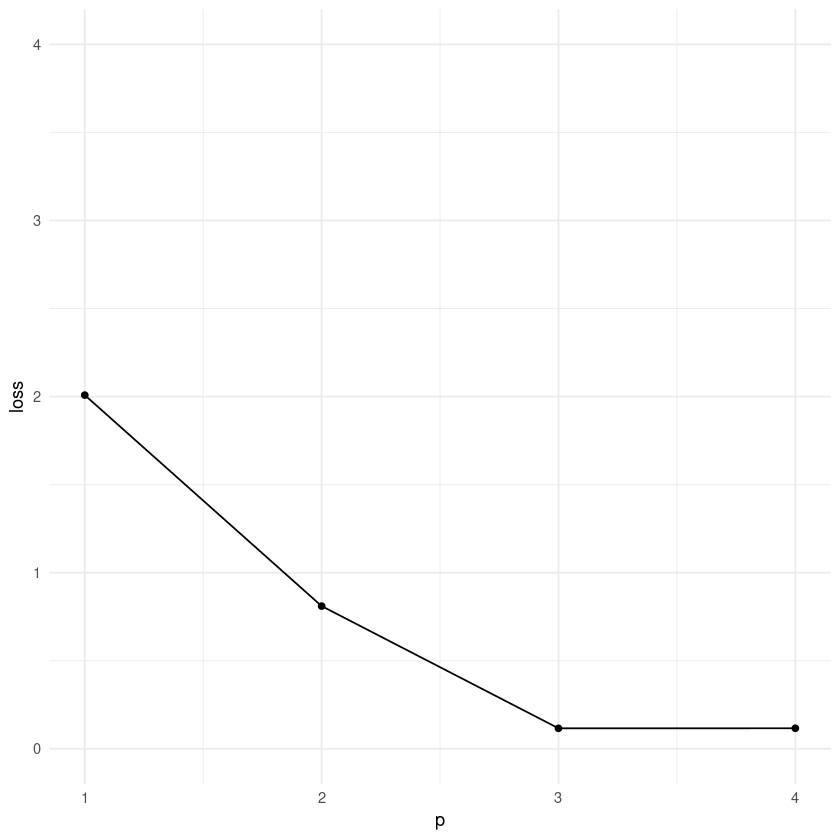

In [15]:
plotlossdatX1 <- data.frame(
    p = 1:4, 
    loss = c(
        maxPCAX1P1$loss_fctn_value,
        maxPCAX1P2$loss_fctn_value,
        maxPCAX1P3$loss_fctn_value,
        maxPCAX1P4$loss_fctn_value
    )
)

pe1 <- ggplot(aes(x = p, y = loss), data = plotlossdatX1) + geom_line() + geom_point() + ylim(0,4) + theme_minimal()
pe1

In [16]:
ggsave("mlm_lindep_elbow.pdf", pe1)

Saving 6.67 x 6.67 in image


In [17]:
rec1 <- t(maxmatmul(maxPCAX1P3$reconstr_matrix, t(X1)))

datX1 <- data.frame(X1)
datX1$is_rec = "original"
datrec1 <- data.frame(rec1)
datrec1$is_rec = "reconstruction"
names(datrec1) <- names(datX1)
plot_datX1 <- full_join(datX1, datrec1)

Joining with `by = join_by(X1, X2, X3, X4, X5, is_rec)`


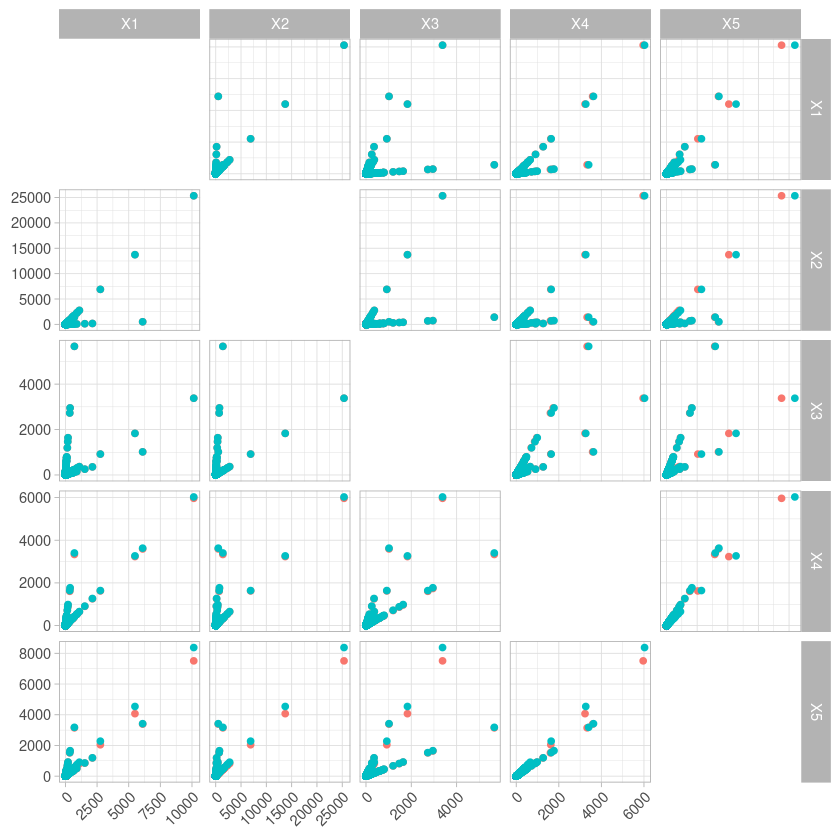

In [18]:
p1 <- ggpairs(
    plot_datX1, 
    aes(color = is_rec), 
    columns = 1:5,
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
p1

In [19]:
ggsave("mlm_lindep.png", p1)

Saving 6.67 x 6.67 in image


# not perfectly reconstructable second model

In [20]:
A2 <- matrix(
    c(
        2/3, 2/3, 0, 0, 1 / 5, 
        0, 1/3, 2/3, 1/3, 3 / 5, 
        1 / 3, 0, 1/3, 2/3, 1 / 5
     ), 
    5, 3
)

In [21]:
A2

0.6666667,0.0000000,0.3333333
0.6666667,0.3333333,0.0000000
0.0000000,0.6666667,0.3333333
0.0000000,0.3333333,0.6666667
0.2000000,0.6000000,0.2000000


In [22]:
Z2 <- matrix(rfrechet(30000), 10000, 3)
X2 <- t(maxmatmul(A2, t(Z2)))
X2trafo <- transform_unitpareto(X2)

In [23]:
length(which(rowSums(X2trafo) > s))

[1] 204

In [24]:
maxPCAX2P1 <- max_stable_prcomp(X2trafo, p=1, s = s, n_initial_guesses = 15000)
maxPCAX2P2 <- max_stable_prcomp(X2trafo, p=2, s = s, n_initial_guesses = 15000)
maxPCAX2P3 <- max_stable_prcomp(X2trafo, p=3, s = s, n_initial_guesses = 15000)
maxPCAX2P4 <- max_stable_prcomp(X2trafo, p=4, s = s, n_initial_guesses = 15000)

In [25]:
maxPCAX2P3

$p
[1] 3

$d
[1] 5

$decoder_matrix
             [,1]         [,2]       [,3]
[1,] 1.2509863384 0.5198032657 0.27352363
[2,] 1.3078925516 0.0007363551 0.00000000
[3,] 0.0002004351 0.3072273941 1.02528216
[4,] 0.0009694941 1.1162258015 0.05126208
[5,] 0.4031852533 0.3245758779 0.83670807

$encoder_matrix
             [,1]         [,2]         [,3]        [,4]        [,5]
[1,] 0.0001951046 0.7645748009 0.0003216588 0.000703759 0.001131084
[2,] 0.0000000000 0.0000000000 0.1342830330 0.895880782 0.000000000
[3,] 0.0000000000 0.0003652442 0.9753614606 0.253690034 0.000000000

$reconstr_matrix
             [,1]         [,2]         [,3]         [,4]         [,5]
[1,] 2.440732e-04 0.9564726307 0.2667844072 0.4656817563 1.414970e-03
[2,] 2.551759e-04 0.9999816872 0.0004206952 0.0009204412 1.479336e-03
[3,] 3.910581e-08 0.0003744784 1.0000207009 0.2752391181 2.267089e-07
[4,] 1.891528e-07 0.0007412507 0.1498901861 1.0000052441 1.096579e-06
[5,] 7.866330e-05 0.3082652848 0.8160928013 0.290781291

In [26]:
estimate_dist(maxPCAX2P3, 10000, 5, t(maxmatmul(maxPCAX2P3$encoder_matrix, t(X2trafo)))[which(rowSums(X2trafo) > s), ])

[1] 2 4 3
             [,1] [,2] [,3]
[1,] 0.000000e+00    0    0
[2,] 5.551115e-17    0    0
           [,1]        [,2]      [,3]       [,4]      [,5]        [,6]
[1,] 0.01688266 0.002403202 0.1507040 0.02365767 0.2025952 0.008086937
[2,] 0.63280548 0.626587960 0.5609185 0.62945991 0.2227948 0.662409658
[3,] 0.35031186 0.371008838 0.2883776 0.34688242 0.5746099 0.329503405
          [,7]       [,8]      [,9]      [,10]     [,11]      [,12]     [,13]
[1,] 0.5319682 0.89683752 0.2008144 0.97110463 0.2247057 0.00384136 0.2124293
[2,] 0.2926927 0.06435487 0.2566928 0.01007987 0.2300875 0.66193784 0.2326779
[3,] 0.1753391 0.03880762 0.5424928 0.01881550 0.5452068 0.33422080 0.5548928
           [,14]      [,15]      [,16]       [,17]      [,18]     [,19]
[1,] 0.988864206 0.94197557 0.97720386 0.002038219 0.92356041 0.2163619
[2,] 0.005552823 0.01969025 0.01049498 0.601243716 0.02562147 0.2265049
[3,] 0.005582971 0.03833418 0.01230116 0.396718065 0.05081812 0.5571332
           [,20]      

[1] 0.4819331

In [27]:
round(maxPCAX2P3$decoder_matrix, 2)

1.25,0.52,0.27
1.31,0.00,0.00
0.00,0.31,1.03
0.00,1.12,0.05
0.40,0.32,0.84


In [28]:
round(maxPCAX2P3$encoder_matrix, 2)

0,0.76,0.00,0.00,0
0,0.00,0.13,0.90,0
0,0.00,0.98,0.25,0


In [29]:
round(maxPCAX2P3$reconstr_matrix, 2)

0,0.96,0.27,0.47,0
0,1.00,0.00,0.00,0
0,0.00,1.00,0.28,0
0,0.00,0.15,1.00,0
0,0.31,0.82,0.29,0


### elbow plot and pairplot to visually inspect fit

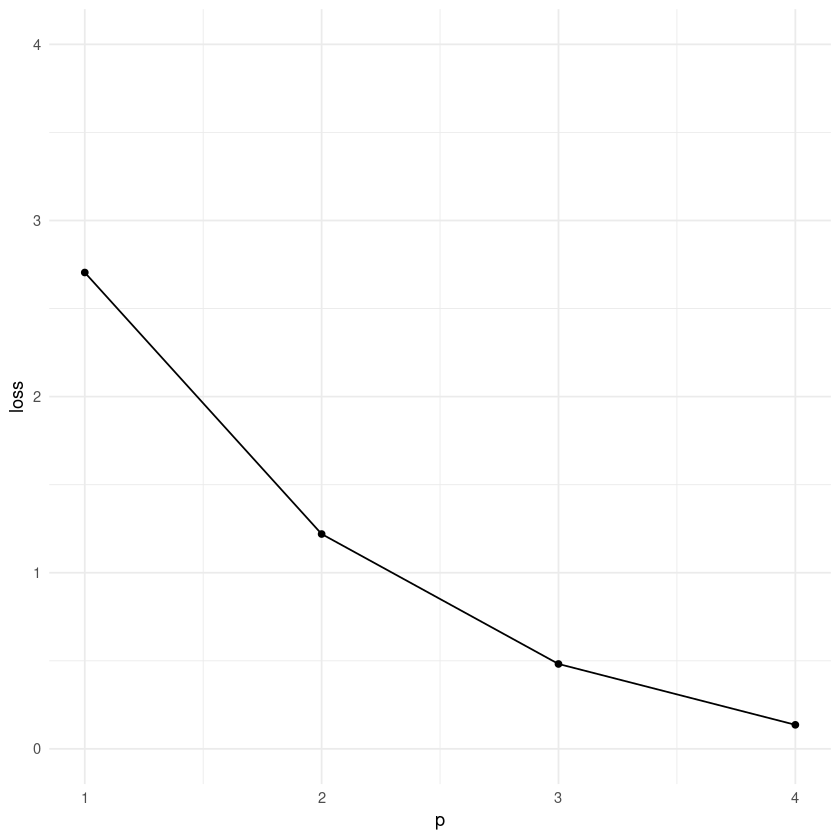

In [30]:
plotlossdatX2 <- data.frame(
    p = 1:4, 
    loss = c(
        maxPCAX2P1$loss_fctn_value,
        maxPCAX2P2$loss_fctn_value,
        maxPCAX2P3$loss_fctn_value,
        maxPCAX2P4$loss_fctn_value
    )
)

pe2 <- ggplot(aes(x = p, y = loss), data = plotlossdatX2) + geom_line() + geom_point() + ylim(0,4) + theme_minimal()
pe2

In [31]:
ggsave("mlm_nolindep_elbow.pdf", pe2)

Saving 6.67 x 6.67 in image


In [32]:
rec2 <- t(maxmatmul(maxPCAX2P3$reconstr_matrix, t(X2)))

datX2 <- data.frame(X2)
datX2$is_rec = "original"
datrec2 <- data.frame(rec2)
datrec2$is_rec = "reconstruction"
names(datrec2) <- names(datX2)
plot_datX2 <- full_join(datX2, datrec2)

Joining with `by = join_by(X1, X2, X3, X4, X5, is_rec)`


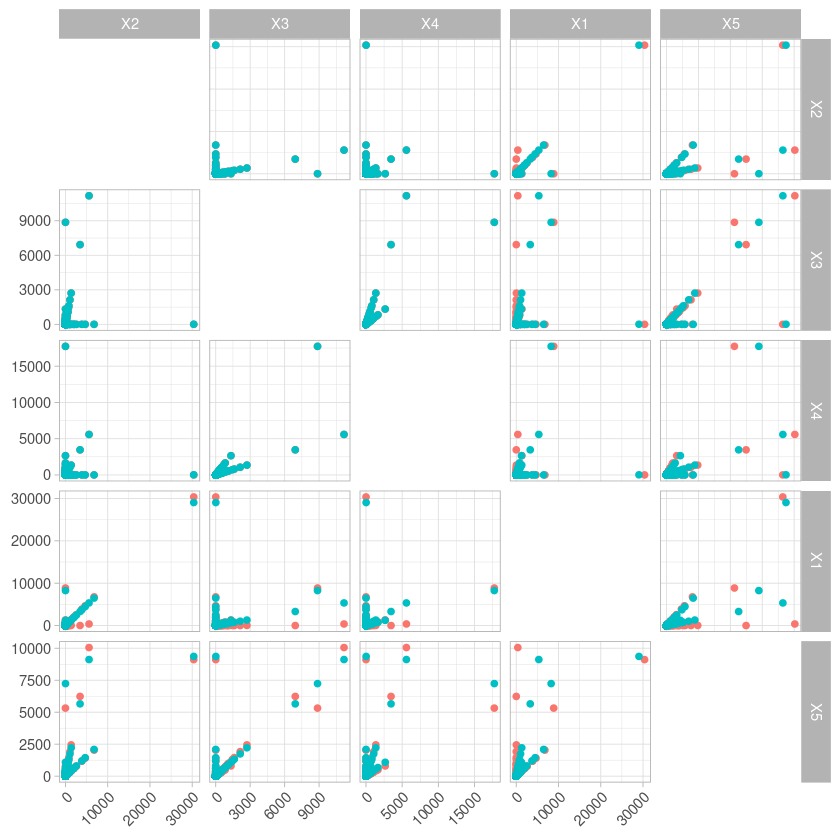

In [33]:
p2 <- ggpairs(
    plot_datX2, 
    aes(color = is_rec),
    columns = c(2,3, 4,1,5),
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

p2

In [34]:
ggsave("mlm_nolindep.png", p2)

Saving 6.67 x 6.67 in image
